# Feature selection in behavior prediction with XGBoost

Copyright 2020 -
Leon Kellner, Merten Stender, Hamburg University of Technology, Germany

https://www2.tuhh.de/skf/

https://cgi.tu-harburg.de/~dynwww/cgi-bin/home/

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation,
either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## 0.1 Packages

In [2]:
# clear jupyter lab workspace without user confirmation
%reset -f  

# data handling modules
import pandas as pd
import numpy as np

# machine learning modules - pre- & postprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# machine learning modules - XGBoost
import xgboost as xgb

# explainable AI
import shap

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# other
import importlib
import pickle

# inhouse modules
import auxiliary_functions as aux  # repeatedly used functions are outsourced to this module
import data_preprocessing as dp    # data preprocessing module
importlib.reload(dp)  # automatic reload (sometimes needed)
importlib.reload(aux)

<module 'auxiliary_functions' from 'D:\\05_Feature_selection\\feature-selection-2020-paper\\auxiliary_functions.py'>

## 0.2 Variables and constants

In [3]:
# control variables - data cleaning
onehot_ = False        # one-hot encode data t/f
freshwater_ = False    # only use freshwater ice data t/f
drop_nan_ = False      # drop all rows that contain nan values after data cleaning t/f, not necessary for XGBoost trees
exp_cat_ = False       # Take exponential of ordinally encoded categorical data to increase distance between categories

# contral variables - code execution
use_kfold = True       # check for overfitting with kfold cross validation
exploratory = False    # do exploratory data analysis  t/f
random_state_ = 7      # random state for reproducible output

# global training constants and hyperparameters
# see also https://xgboost.readthedocs.io/en/latest/parameter.html
MAX_LEAVES = 8             # p. 363, T. Hastie et al., The elements of statistical learning: Data mining, inference, and prediction, 2009.
LEARNING_RATE = 0.07       # J. H. Friedman, “Stochastic gradient boosting,” Computational Statistics & Data Analysis, vol. 38, no. 4, pp. 367–378, 2002
SUBSAMPLE = 0.5            # Also Friedman paper
NUM_BOOST_ROUNDS = 500     # Number of gradient boosted trees. Equivalent to number of boosting rounds.
EARLY_STOPPING_ROUNDS = 5  # Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training
EVAL_METRICS = ['auc', 'logloss']  # last metric in this list will be used for early stopping during training
OBJECTIVE = "binary:logistic"      # logistic regression loss function for binary classification

# some general variables for postprocessing
dpi_ = 1000                     # resolution for figures
fig_size_ = aux.cm2inch(12, 8)  # figure size

# file name templates for saving files, figures and models
fig_path_name_template = "raw_figures/clf_xgb_sw_"    
excel_path_name_template = 'excel_outputs/clf_xgb_sw_'
model_path_name_template = 'models/clf_xgb_sw_'
if freshwater_:
    fig_path_name_template = "raw_figures/clf_xgb_fw_"
    excel_path_name_template = 'excel_outputs/clf_xgb_fw_'
    model_path_name_template = 'models/clf_xgb_fw_'

## 1. Import and prepare data

In [4]:
file = 'data points_v1.12.xlsx'
data = dp.data_cleaning(filename=file)  # method agnostic initial data cleaning

# method specific data cleaning & split into encoded and non-encoded data
# Display datasets are not encoded or scaled, and will be used in visualization later
X, y, X_display, y_display = dp.data_prep_behavior_pred(data, freshwater=freshwater_, onehot=onehot_, 
                                                        drop_nan=drop_nan_, exp_cat=exp_cat_)
num_features = X.shape[1]
num_samples = data.shape[0]
X.to_excel(excel_path_name_template + 'X.xlsx',index=True, header=True)
X_display.to_excel(excel_path_name_template + 'X_display.xlsx',index=True, header=True)

# train, test, and validation splits
split = 0.2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=split, stratify=y, random_state = random_state_)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split, stratify=y_train_val, random_state = random_state_)  

# tidy features names for later visualizations 
if freshwater_:
    name_map = {
        "strain_rate": "Strain rate",
        "triaxiality": "Triaxiality",
        "temperature": "Temperature",
        "volume": "Volume",
        "porosity": "Porosity",
        "grain_size": "Grain size", 
        "type_test": "Type of test",
        "columnar_loading": "Columnar loading",
        "type_ice": "Type of ice",
    }
else:
    name_map = {
        "temperature": "Temperature",
        "columnar_loading": "Columnar loading",
        "strain_rate": "Strain rate",
        "type_ice": "Type of ice",
        "porosity": "Porosity",
        "volume": "Volume",
        "type_test": "Type of test",
        "salinity": "Salinity", 
        "triaxiality": "Triaxiality",
    }
display_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

X_display.head()

Uniaxial tension and shear tests removed from data set.
Binarized behavior:  brittle  =  0
Encoded columnar loading:  across  =  0
Encoded type of ice:  columnar  =  0.0


,type_test,strain_rate,temperature,porosity,salinity,type_ice,columnar_loading,triaxiality,volume
original_index,,,,,,,,,
330,uniaxial compression,-0.800894,-11.0,NaN,2.4,columnar,across,-0.333333,432000.0
331,uniaxial compression,-0.904736,-11.0,NaN,2.4,columnar,across,-0.333333,432000.0
332,uniaxial compression,-1.178982,-11.0,NaN,2.4,columnar,across,-0.333333,432000.0
333,uniaxial compression,-0.929590,-11.0,NaN,2.4,columnar,across,-0.333333,432000.0
334,uniaxial compression,-0.798099,-11.0,NaN,2.4,columnar,across,-0.333333,432000.0


## 1.1 Exploratory data analysis

In [5]:
if exploratory:
    # check and output shapes and features
    print(X.shape, y.shape, X_display.shape, y_display.shape)   
    print(f'number of input feautures: {num_features}')
    print(f'number of samples (overall): {num_samples}')

    # a histogram of all inputs
    hist_inputs = X.hist(layout=(3,3), figsize=(10,10));
    plt.show()

    # a histogram of all outputs
    print('targets: number of behavior type 1: ' + str(np.sum(y)))
    print('targets: number of behavior type 0: ' + str(len(y)-np.sum(y)))
    print('the imbalance is: ' + str(np.sum(y)/y.shape*100) + ':' + str((len(y)-np.sum(y))/y.shape*100))
    print('the expected value is:' + str(np.round(np.mean(y),2)))
    hist_outputs = y.hist();
    plt.xlabel('target value')
    plt.show()

## 2. XGBoost model preparation & cross validation 

In [6]:
# --- model building and training function
def build_train_model(Dtrain, Deval):
    """Build and train XGBoost model.

    Parameters
    ----------
    Dtrain, Dtest : xgboost.DMatrix
        Train and test/evaluation data sets in native XGBoost format.


    Returns
    -------
    xgboost.Booster, dictionary

    """
    parameters_booster = {
        "max_leaves": MAX_LEAVES,             
        "grow_policy": 'lossguide',  # needs to be defined for max_leaves parameter
        "tree_method": 'hist',       # needs to be defined for max_leaves parameter
        "learning_rate": LEARNING_RATE,       
        "subsample": SUBSAMPLE,            
        "objective": OBJECTIVE,     
        "eval_metric": EVAL_METRICS,  
    }
    progress = dict()  # training progress
    
    # compile and train model, return model and training progress
    model = xgb.train(parameters_booster, Dtrain, verbose_eval=False,  
                      evals=[(Dtrain, 'train'), (Deval, 'eval')],
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      evals_result=progress, num_boost_round=NUM_BOOST_ROUNDS)
    return model, progress

# --- model checking
# use cross validation to find out whether the model architecture is well suited for the problem
metrics_cv = {'acc': [], 'mcc': []}  # store the results in a dict
if use_kfold:  
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    for train, test in kfold.split(X_train_val, y_train_val):
        
        # split fold test data into validation set for early stopping and test set for performance evaluation
        Xfold_eval, Xfold_test, yfold_eval, yfold_test = train_test_split(X_train_val.iloc[test, :], y_train_val.iloc[test], test_size=0.5, 
                                                                          stratify=y_train_val.iloc[test], random_state = random_state_)
        Dtrain = xgb.DMatrix(X_train_val.iloc[train, :], y_train_val.iloc[train])  # the current training data in native XGBoost format
        Deval = xgb.DMatrix(Xfold_eval, yfold_eval)     # Validation data for early stopping
        model, progress = build_train_model(Dtrain, Deval)
        current_metrics = aux.binary_classif_metrics_xgb(model, Xfold_test, yfold_test)  # evaluation of model performance on current test data 
        metrics_cv['mcc'].append(current_metrics[0])
        metrics_cv['acc'].append(current_metrics[1])
    
    # add mean of kfold metric values
    metrics_cv['acc_mean'] = np.mean(metrics_cv['acc'])
    metrics_cv['mcc_mean'] = np.mean(metrics_cv['mcc'])
    
    # report the CV results
    print('cross-validation performance ACC :', np.round(metrics_cv['acc'], 2), ', mean: ', str(np.round(metrics_cv['acc_mean'], 2)))
    print('cross-validation performance MCC :', np.round(metrics_cv['mcc'], 2), ', mean: ', str(np.round(metrics_cv['mcc_mean'], 2)))

cross-validation performance ACC : [0.8  0.87 0.86 0.85 0.87] , mean:  0.85
cross-validation performance MCC : [0.55 0.69 0.67 0.64 0.69] , mean:  0.65


## 3. Train the final classifier

test set score of the final classifier - ACC:  0.86
test set score of the final classifier - MCC:  0.68


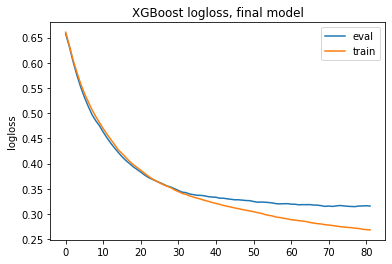

In [7]:
metrics_final = {}
Dtrain = xgb.DMatrix(X_train, y_train)  # convert training data to XGBoost native data format
Deval = xgb.DMatrix(X_val, y_val)

# build final model, save training progress, and get predictions
model, progress_final = build_train_model(Dtrain, Deval)
pickle.dump(model, open(model_path_name_template + "pickle.dat", "wb"))

# report the results of the final classifier on the test data set
metrics_final['mcc_test'], metrics_final['acc_test'] = aux.binary_classif_metrics_xgb(model, X_test, y_test)
print('test set score of the final classifier - ACC: ', str(np.round(metrics_final['acc_test'],2)))
print('test set score of the final classifier - MCC: ', str(np.round(metrics_final['mcc_test'],2)))

# plot the training history of the final classifier
plot_metric = aux.is_list(EVAL_METRICS, -1)  # If eval_metric is list, get last entry (used for early stopping)
x_axis = range(0, len(progress_final['eval'][plot_metric]))
fig, ax = plt.subplots()
ax.plot(x_axis, progress_final['eval'][plot_metric], label='eval')
ax.plot(x_axis, progress_final['train'][plot_metric], label='train')
ax.legend()
plt.ylabel(plot_metric)
plt.title('XGBoost ' + plot_metric + ', final model')
plt.show()

# use the following hack for shap 1.1 until this issue is fixed: https://github.com/slundberg/shap/issues/1215
# https://github.com/slundberg/shap/issues/1215#issuecomment-641102855
model_bytearray = model.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
model.save_raw = myfun

## 4. Postprocessing of results

## 4.1 Confusion matrix and test/misclassified data subsets

In [8]:
y_predict = model.predict(xgb.DMatrix(X_test))
y_predict = (y_predict > 0.5).astype(int)  # convert probabilities to classes
y_predict_df = pd.DataFrame(y_predict)     # predicted classes as pandas dataframe
y_misclassified = ~(y_test == y_predict)   # boolean vector for test predictions, where y_miscl[i] is true if the model misclassified observation X_test[i]
X_test_misclassified = X_test.loc[y_misclassified.values, :]  # take only misclassified observations

# save different datasets as excel tables for external use
y_predict_df.to_excel(excel_path_name_template + 'y_predict.xlsx',index=False, header=False)  
y_test.to_excel(excel_path_name_template + 'y_test.xlsx',index=False, header=False)
X_test.to_excel(excel_path_name_template + 'X_test.xlsx',index=True, header=True)
X_test_misclassified.to_excel(excel_path_name_template + 'X_test_misclassified.xlsx',index=True, header=True)
del y_predict_df

# Double check shapes, if desired
#print(X_test.shape)
#print(y_test.shape)
#print(y_predict.shape)
#print(y_misclassified.shape)
#print(X_test_misclassified.shape)

## 4.2 Explain predictions for all observations

In [9]:
shap.initjs()  # necessary for shap visualization
print('The binarized value of', y_display.iloc[0], 'behavior is', y.iloc[0])  # Output binarized and display value

# representative data set if needed
if freshwater_:  # Because the freshwater data set is small, take the whole data
    background_data = X_train
else:  # The saltwater data set is big, so take n samples as representative data set
       # Only use data without NaN, else kmeans does not work
    background_data = shap.kmeans(X_train.dropna(inplace=False), 200)  

explainer = shap.TreeExplainer(model)   # if no background data is given, feature perturbation is automatically observational (https://shap.readthedocs.io/en/latest/#shap.TreeExplainer)
shap_values = explainer.shap_values(X)  # SHAP values for all data. This is fast for boosted trees, no specific background data needed (in contrast to KernelExplainer)

# save test shap values to excel
df_shap_values = pd.DataFrame(shap_values)  # create dataframe for shap values
df_shap_values.to_excel(excel_path_name_template + 'shap_values.xlsx',index=True, header=True) 

# check shape if desired - should be the same as data matrix
print('Shape of shap values: ', shap_values.shape)  
print('Shape of data matrix: ', X.shape)

The binarized value of brittle behavior is 0


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Shape of shap values:  (1769, 9)
Shape of data matrix:  (1769, 9)


### Importance of features
SHAP importance ranking for the complete data set. 

<function matplotlib.pyplot.show(*args, **kw)>

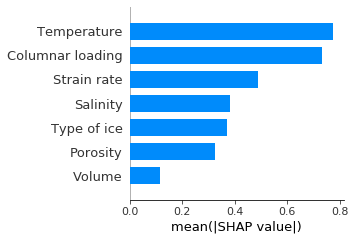

In [10]:
max_display_ = 7  # max. number of features to include in plots
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values, X, feature_names=display_feature_names, plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar.pdf", format='pdf',  dpi=dpi_)  
plt.show

### SHAP summary plot

Path =  raw_figures/clf_xgb_sw_summary.pdf


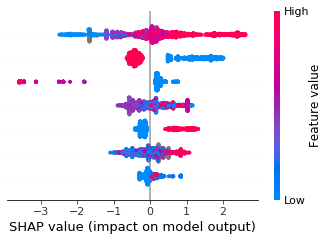

In [11]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values, X, 
                  feature_names=["" for m in display_feature_names],  # omit feature names in this summary plot
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary.pdf", dpi=dpi_, format='pdf')
plt.show
print("Path = ", fig_path_name_template + "summary.pdf")

## 4.4 Analysis of SHAP values for test and misclassified observations
### Have a closer look at testing shap values and potentially identify error sources. Begin with test data.
The classification for saltwater ice when the true label is brittle does not perform well. The analysis below seeks to identify any peculiarties regarding SHAP values for model output and log loss of the model. This is done for different data subsets to see if there are any differences.

In [12]:
shap_values_test = explainer.shap_values(X_test)      # Estimate SHAP values for testing data
df_shap_values_test = pd.DataFrame(shap_values_test)  # create dataframe for test shap values

# save test shap values to excel
df_shap_values_test.to_excel(excel_path_name_template + 'shap_values_test.xlsx',index=True, header=True)  

# locate misclassified values and save to excel file
df_shap_values_test.loc[y_misclassified.values, :].to_excel(excel_path_name_template + 'shap_values_test_misclassified.xlsx',index=True, header=True)  

Plot ranking and summary plot for test data only

<function matplotlib.pyplot.show(*args, **kw)>

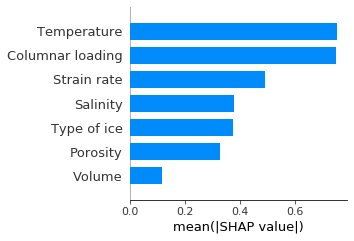

In [13]:
max_display_ = 7
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test, X_test, feature_names=display_feature_names, 
                  plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_testdata.pdf", format='pdf',  dpi=dpi_)  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

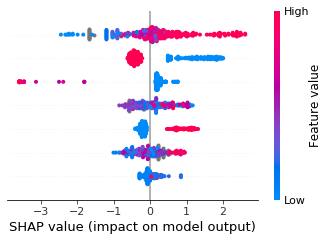

In [14]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test, X_test, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary_testdata.pdf", dpi=dpi_, format='pdf')
plt.show

### Look at shap values for misclassified data

<function matplotlib.pyplot.show(*args, **kw)>

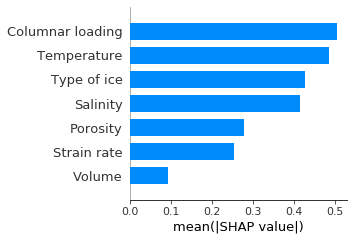

In [15]:
shap_values_test_miscl = shap_values_test[y_misclassified.values, :]

max_display_ = 7
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test_miscl, X_test_misclassified, feature_names=display_feature_names, 
                  plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_testdata_miscl.pdf", format='pdf',  dpi=dpi_)  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

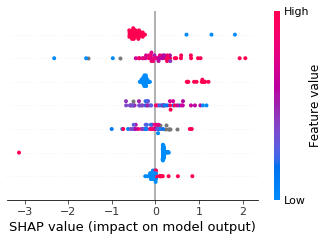

In [16]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test_miscl, X_test_misclassified, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary_testdata_miscl.pdf", dpi=dpi_, format='pdf')
plt.show

### Check equality of SHAP value matrices, depending on approach

Check how different subsets influence the SHAP values. Theoretically, only the ranking should change, not the values themselves. The explainer is only model dependent, if no background data is given. 

The two approaches should yield the same results: (i) computing SHAP values based on the test data, and then extracting the SHAP values for the misclassified data or (ii) computing SHAP values based on the misclassified data.

SHAP values for both approaches are the same? :  True


<function matplotlib.pyplot.show(*args, **kw)>

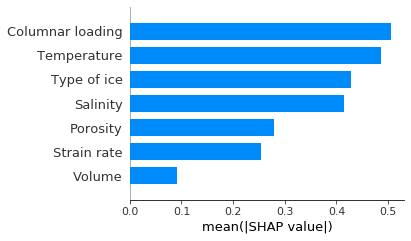

In [17]:
shap_values_test_miscl_only = explainer.shap_values(X_test_misclassified)  # Estimate SHAP values for misclassified data only
pd.DataFrame(shap_values_test_miscl_only).to_excel(excel_path_name_template + 'shap_values_test_miscl_only.xlsx',index=True, header=True)

# check if shap values for both approaches are the same
print('SHAP values for both approaches are the same? : ', (shap_values_test_miscl_only == shap_values_test_miscl).all())

max_display_ = 7
f = plt.figure(figsize=aux.cm2inch(14, 8))
shap.summary_plot(shap_values_test_miscl_only, X_test_misclassified, feature_names=display_feature_names, 
                  plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_miscl_only.pdf", format='pdf',  dpi=dpi_)  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

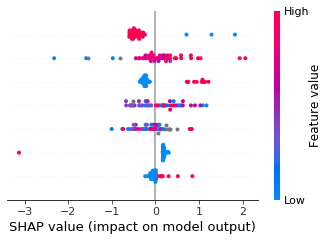

In [18]:
f = plt.figure(figsize=aux.cm2inch(12, 8))
shap.summary_plot(shap_values_test_miscl_only, X_test_misclassified, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary_miscl_only.pdf", dpi=dpi_, format='pdf')
plt.show

## 4.5 Analysis of SHAP values for log loss
### Log loss for all data

<function matplotlib.pyplot.show(*args, **kw)>

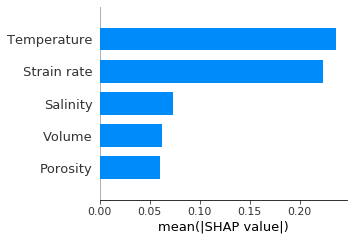

In [19]:
explainer_logloss = shap.TreeExplainer(model, data = background_data, feature_perturbation="interventional", model_output="log_loss")
shap_values_logloss = explainer_logloss.shap_values(X, y)

pd.DataFrame(shap_values_logloss).to_excel(excel_path_name_template + 'shap_values_logloss.xlsx',index=True, header=True)

max_display_ = 5
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_logloss, X, feature_names=display_feature_names, plot_type="bar", 
                  plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_logloss.pdf", format='pdf',  dpi=dpi_)  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

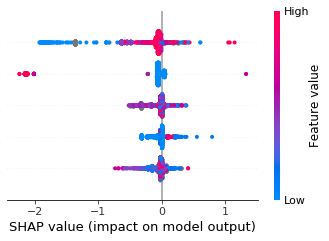

In [20]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_logloss, X, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary_logloss.pdf", dpi=dpi_, format='pdf')
plt.show

### Log loss for test data

<function matplotlib.pyplot.show(*args, **kw)>

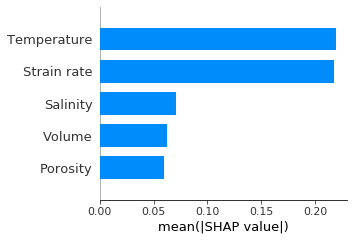

In [21]:
explainer_logloss_test = shap.TreeExplainer(model, data = background_data, feature_perturbation="interventional", model_output="log_loss")
shap_values_logloss_test = explainer_logloss_test.shap_values(X_test, y_test)

max_display_ = 5
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_logloss_test, X_test, feature_names=display_feature_names, 
                  plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_testdata_logloss.pdf", format='pdf',  dpi=dpi_)  # https://stackoverflow.com/a/54945630
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

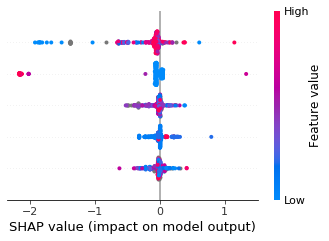

In [22]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_logloss_test, X_test, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary_testdata_logloss.pdf", dpi=dpi_, format='pdf')
plt.show

### Log loss for misclassified test data

<function matplotlib.pyplot.show(*args, **kw)>

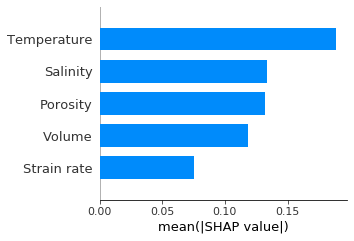

In [23]:
shap_values_test_logloss_miscl = shap_values_logloss_test[y_misclassified.values, :]

max_display_ = 5
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test_logloss_miscl, X_test_misclassified, feature_names=display_feature_names, 
                  plot_type="bar", plot_size=None, show=False, max_display=max_display_)
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "ranking_bar_testdata_logloss_miscl.pdf", format='pdf',  dpi=dpi_)  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

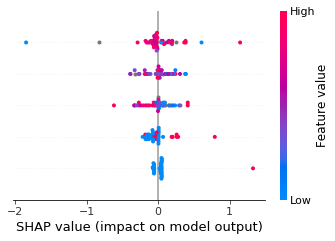

In [24]:
f = plt.figure(figsize=fig_size_)
shap.summary_plot(shap_values_test_logloss_miscl, X_test_misclassified, feature_names=["" for m in display_feature_names], 
                  show=False, plot_size=None, max_display=max_display_)
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "summary_testdata_logloss_miscl.pdf", dpi=dpi_, format='pdf')
plt.show

## 4.5 Interaction effects
### Have a look at dependence plots of all feature combinations and save noteworthy ones 

### Save specific dependence plots

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

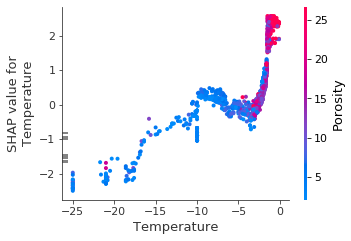

In [25]:
figsize_temp = aux.cm2inch(12,8)
f = plt.figure()
interaction_index_ = 'Porosity'
shap.dependence_plot('Temperature', shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False)
plt.gcf().set_size_inches(figsize_temp)  # this line might be needed if dependence plot ignores figure size setting
plt.tight_layout(pad=0)
plt.savefig(fig_path_name_template + "dependence_temperature_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

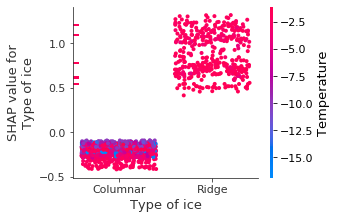

In [26]:
x_jitter_ = 0.8
f = plt.figure()
interaction_index_ = 'Temperature'
shap.dependence_plot('Type of ice', shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
plt.xticks(np.arange(2), ('Columnar', 'Ridge'))
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + "type_ice" + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

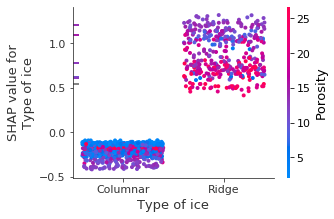

In [27]:
f = plt.figure()
interaction_index_ = 'Porosity'
shap.dependence_plot('Type of ice', shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
plt.xticks(np.arange(2), ('Columnar', 'Ridge'))
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + "type_ice" + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

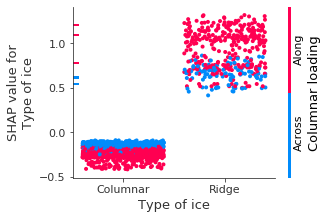

In [28]:
f = plt.figure()
interaction_index_ = 'Columnar loading'
shap.dependence_plot('Type of ice', shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(['Across', 'Along'])
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
cbar.set_ticks([0.35, 0.82])
plt.xticks(np.arange(2), ('Columnar', 'Ridge'))
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + "type_ice" + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

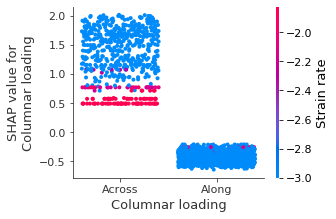

In [29]:
f = plt.figure()
main_index = 'Columnar loading'
interaction_index_ = 'Strain rate'
shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
plt.xticks(np.arange(2), ('Across', 'Along'))
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

invalid value encountered in less


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

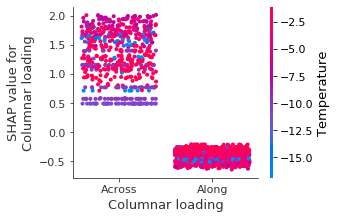

In [30]:
f = plt.figure()
main_index = 'Columnar loading'
interaction_index_ = 'Temperature'
shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
plt.xticks(np.arange(2), ('Across', 'Along'))
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

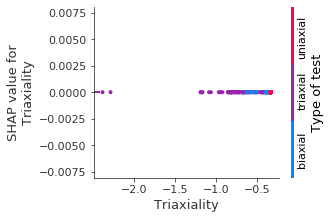

In [31]:
f = plt.figure()
main_index = 'Triaxiality'
interaction_index_ = 'Type of test'
shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=interaction_index_, show=False, x_jitter=x_jitter_)
cbar = plt.gca().collections[0].colorbar
cbar.set_ticklabels(['biaxial', 'triaxial', 'uniaxial'])
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation='vertical')
cbar.set_ticks([0.5, 1.2, 1.85])
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + interaction_index_ + ".pdf", dpi=dpi_, format='pdf')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 432x288 with 0 Axes>

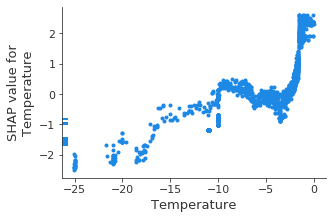

In [32]:
f = plt.figure()
main_index = 'Temperature'
shap.dependence_plot(main_index, shap_values, X, feature_names=np.array(display_feature_names), 
                     interaction_index=None, show=False, x_jitter=2)
plt.gcf().set_size_inches(figsize_temp) 
plt.tight_layout()
plt.savefig(fig_path_name_template + "dependence_" + main_index + "_" + 'Temperature' + ".pdf", dpi=dpi_, format='pdf')
plt.show

### Plot all combinations
If desired, have a look at all possible feature combinations.

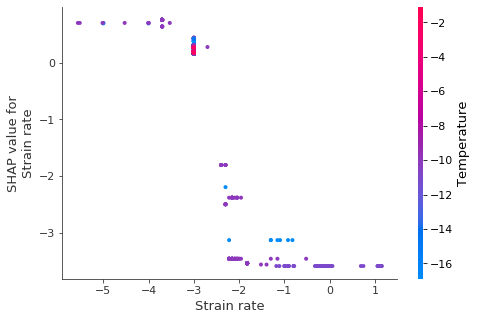

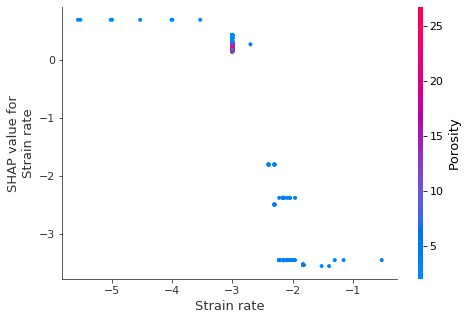

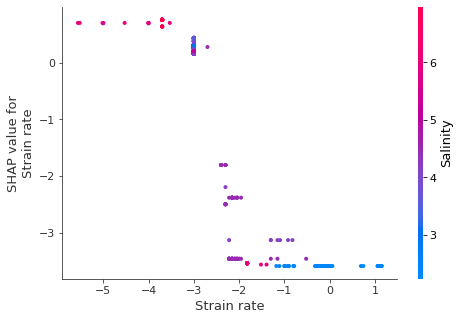

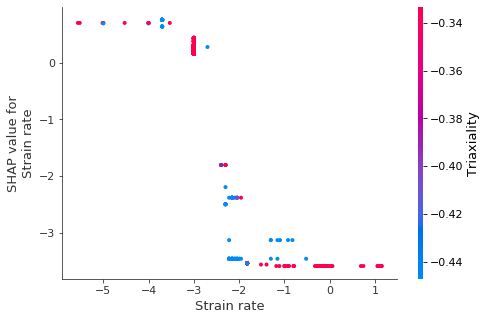

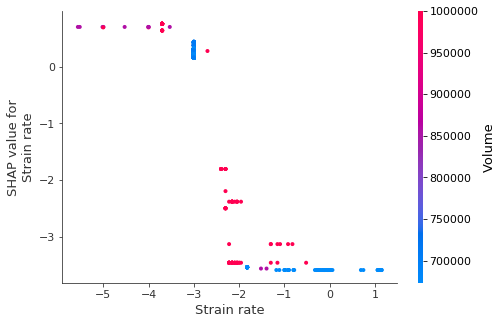

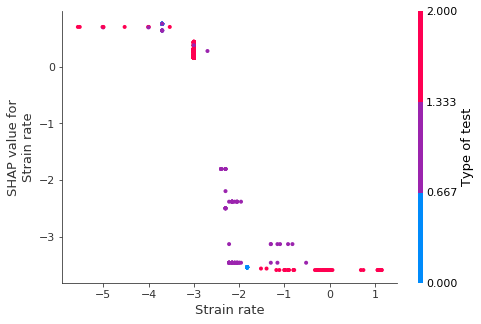

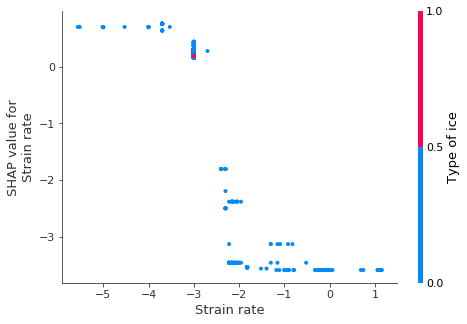

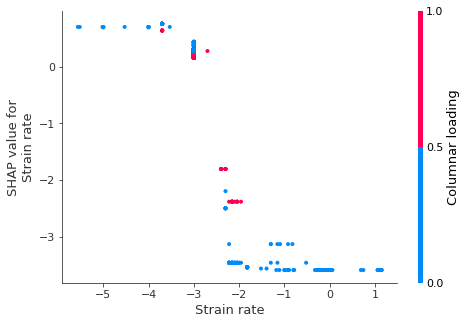

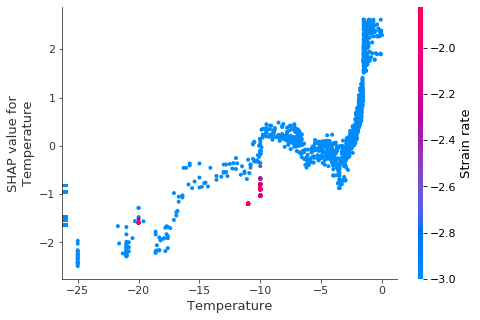

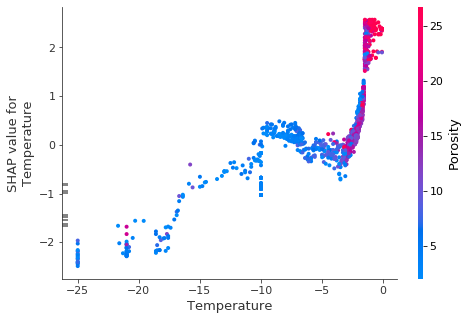

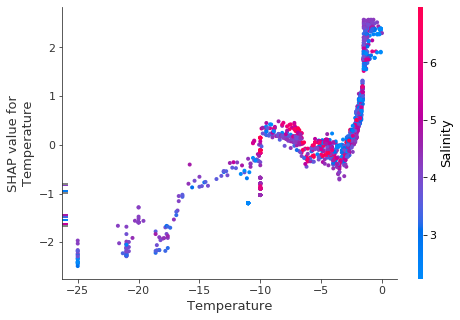

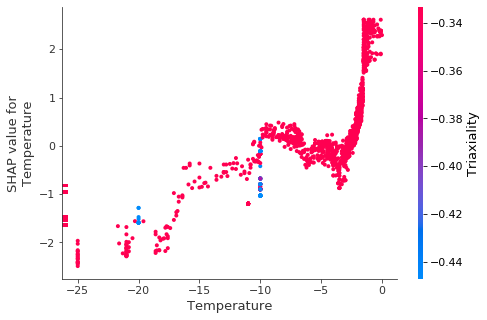

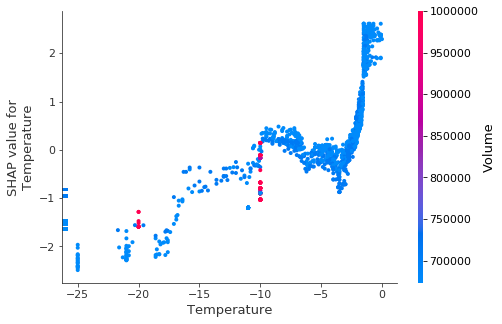

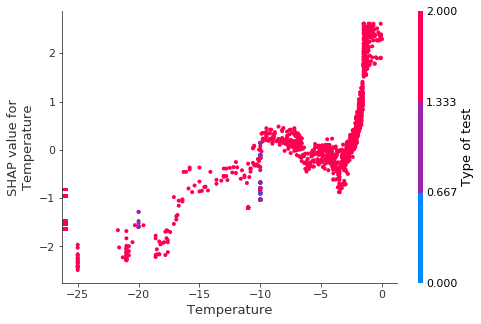

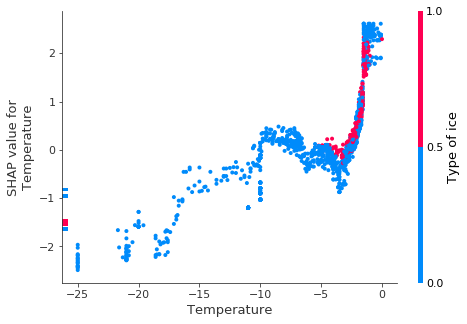

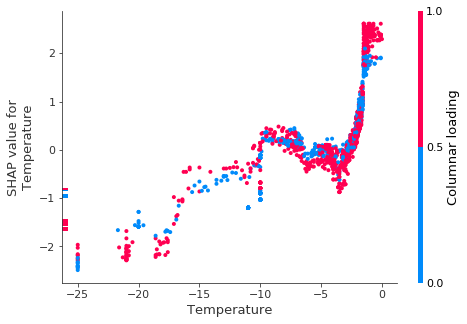

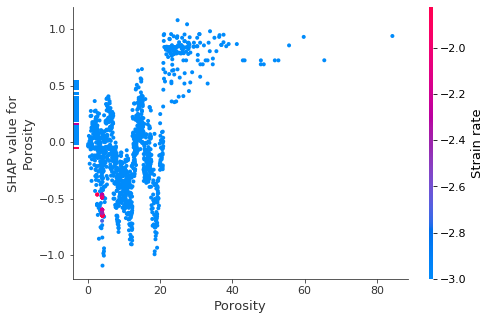

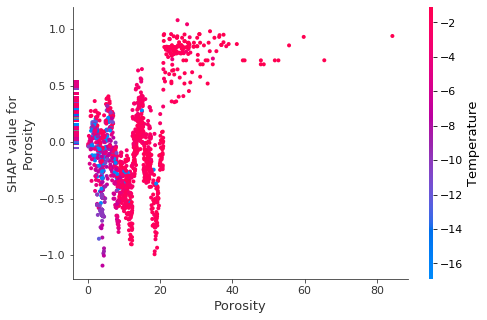

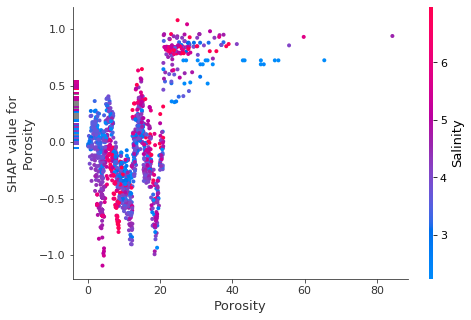

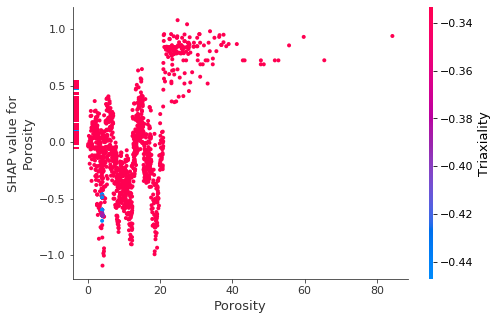

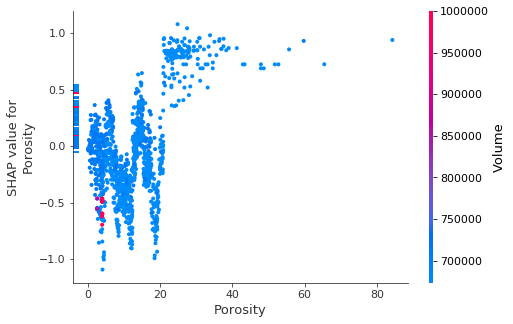

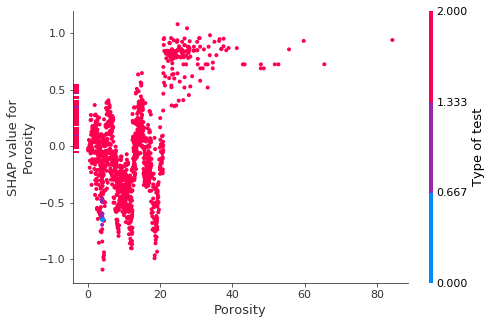

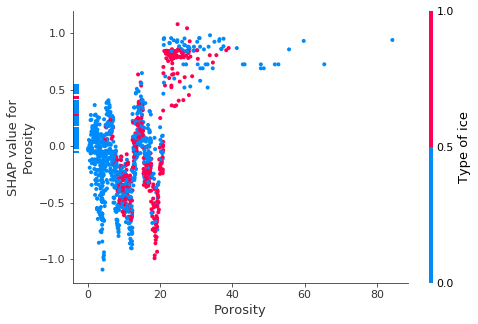

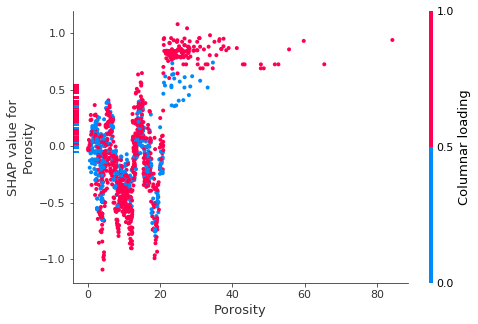

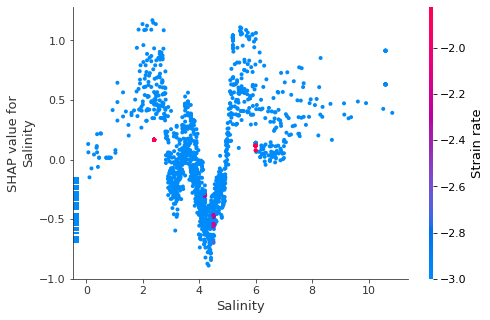

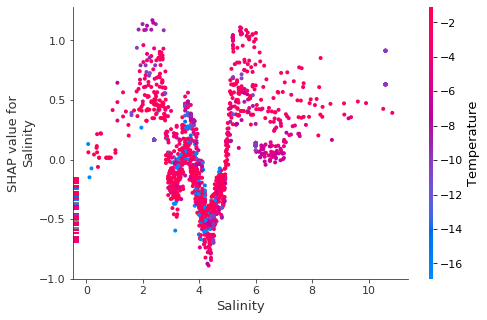

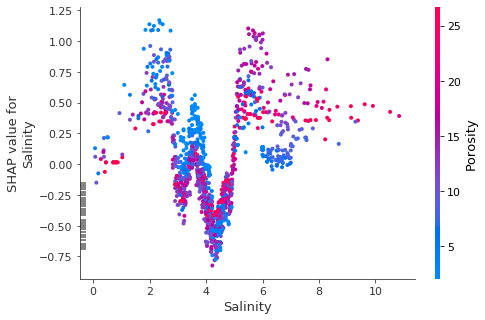

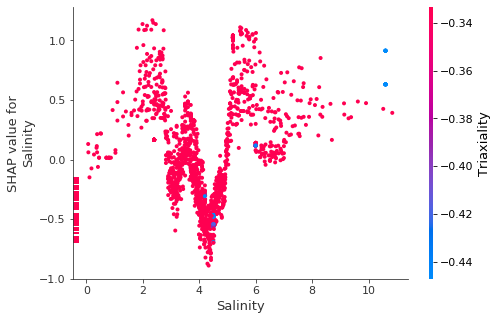

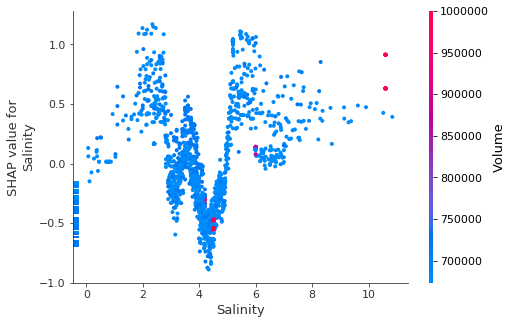

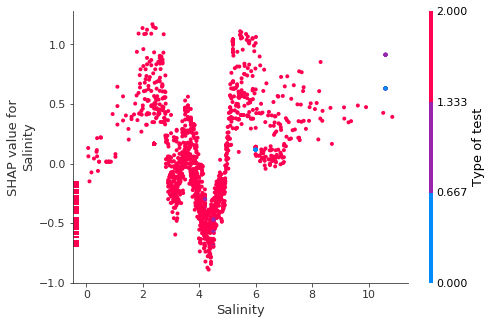

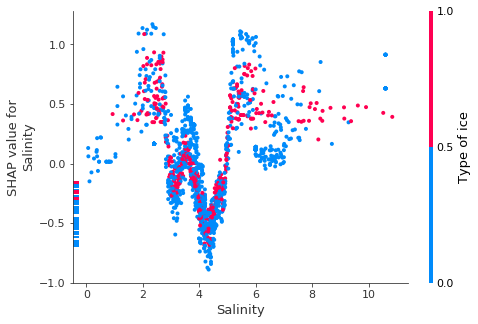

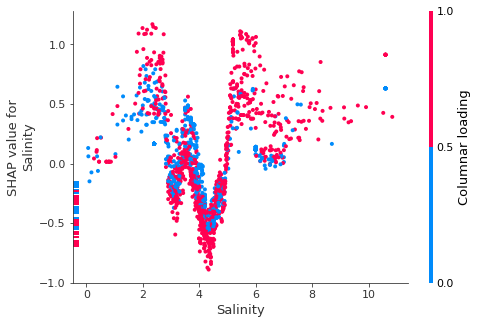

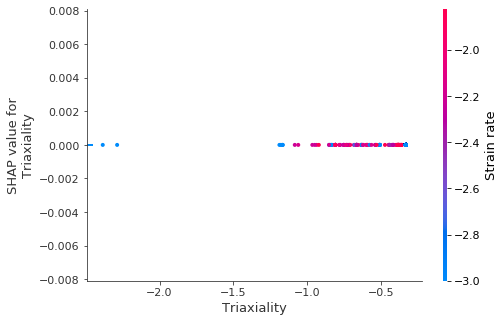

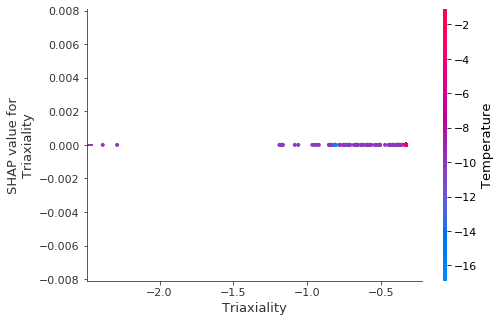

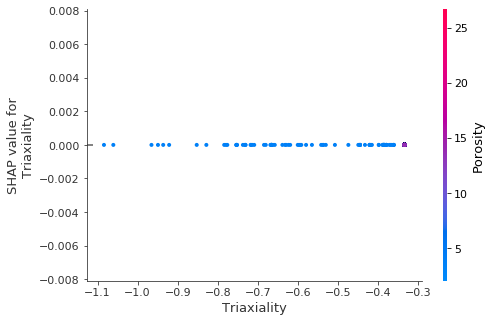

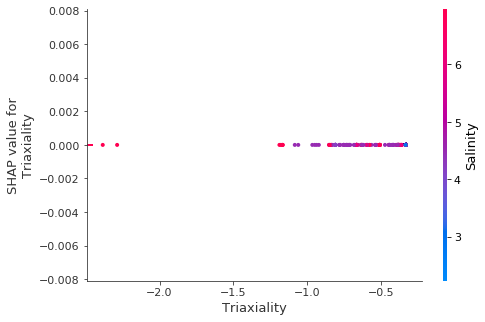

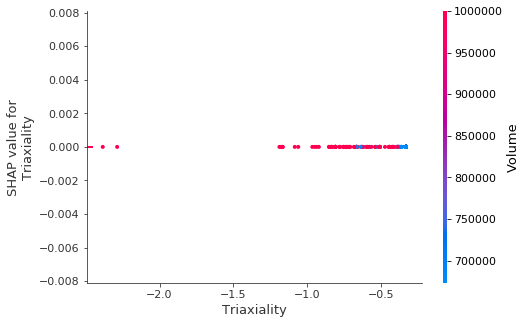

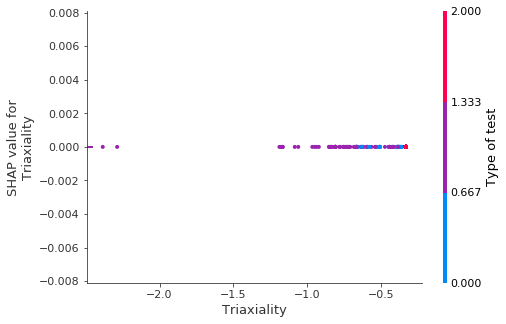

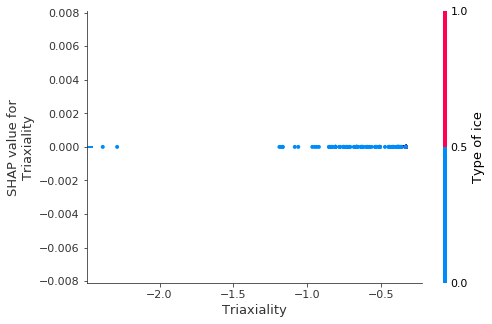

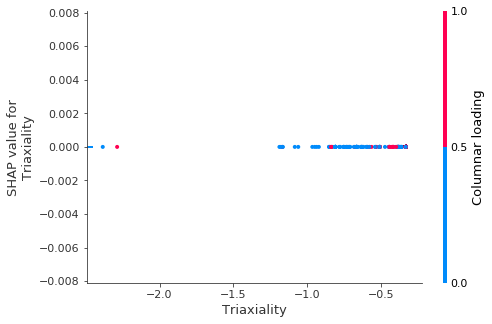

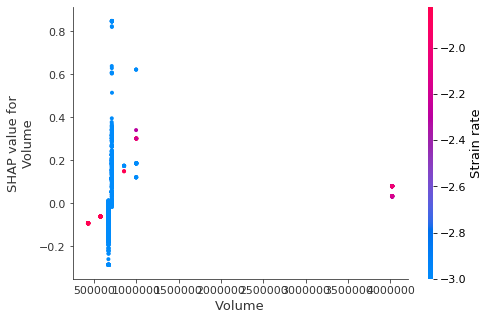

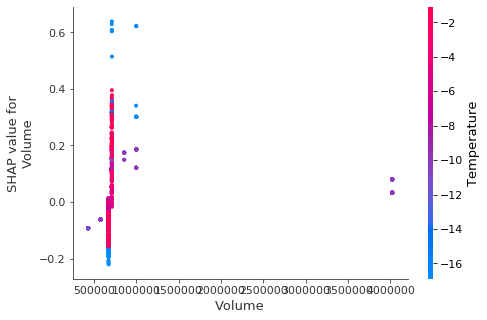

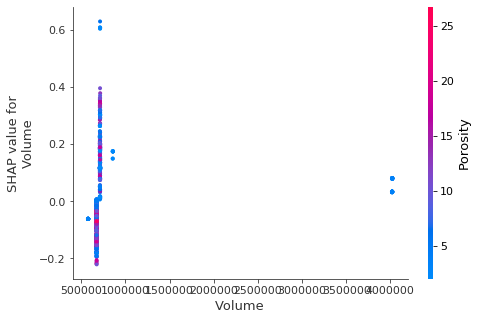

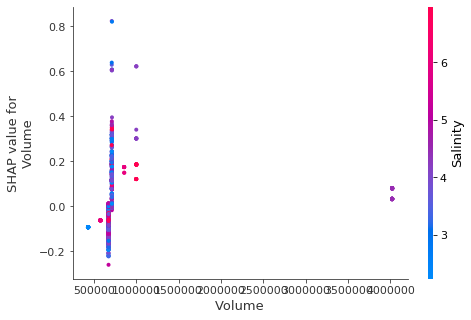

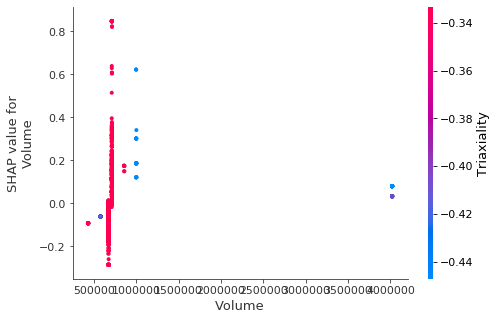

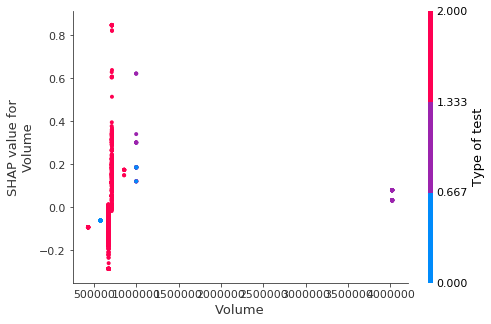

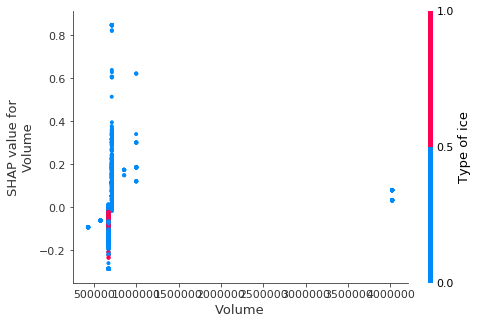

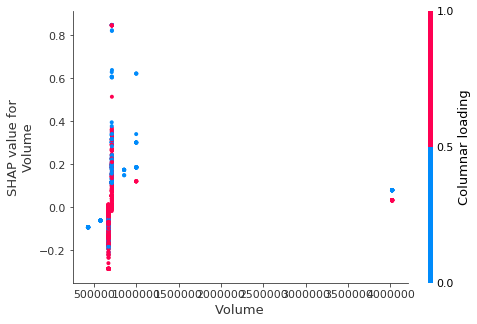

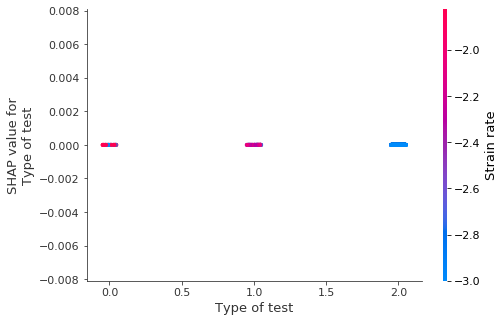

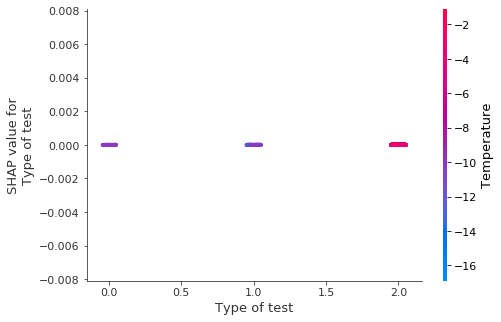

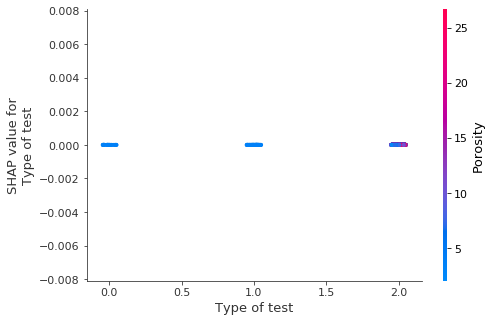

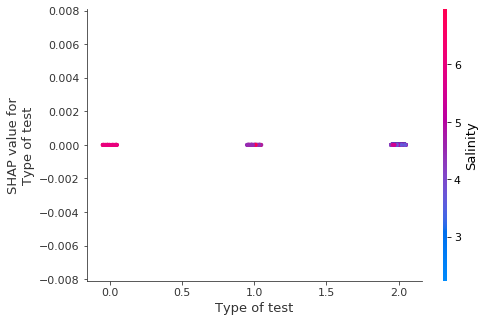

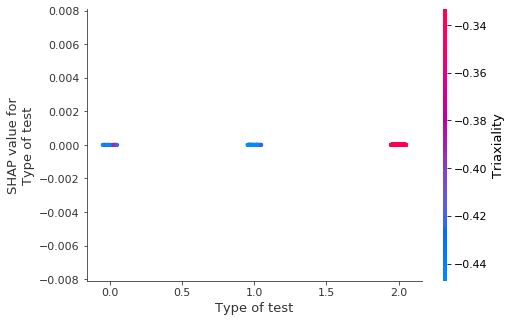

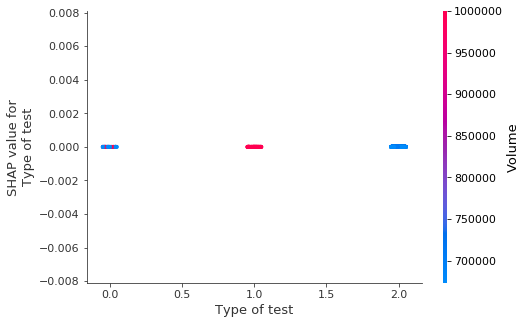

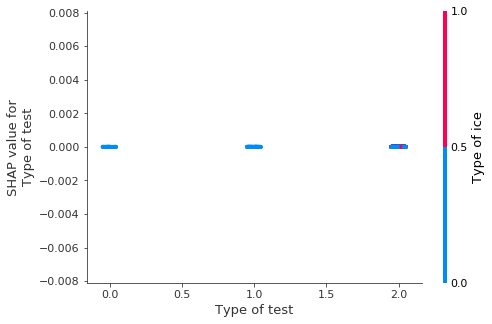

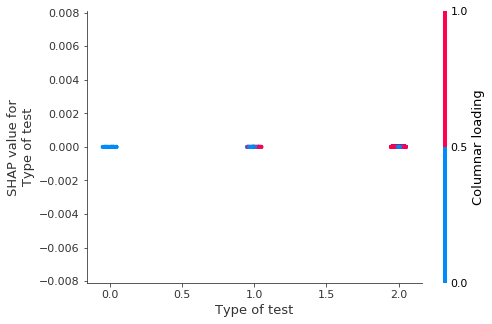

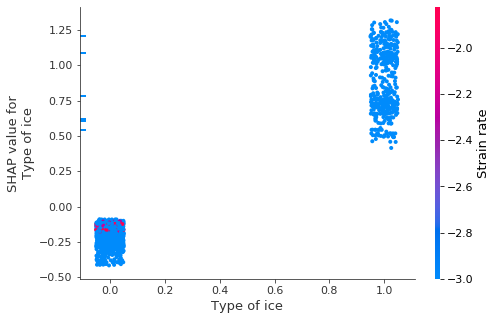

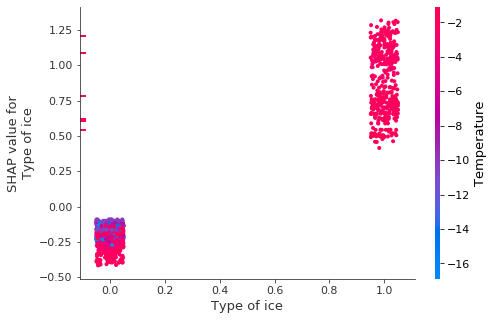

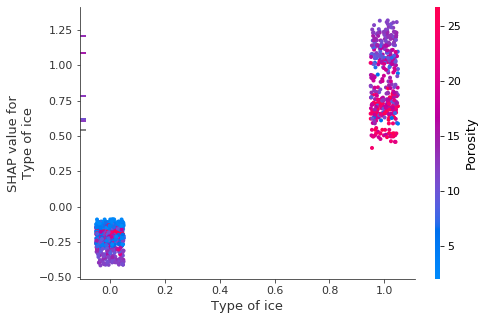

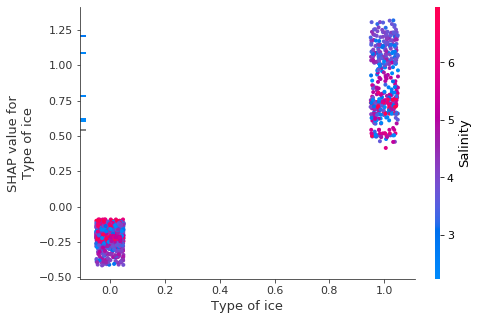

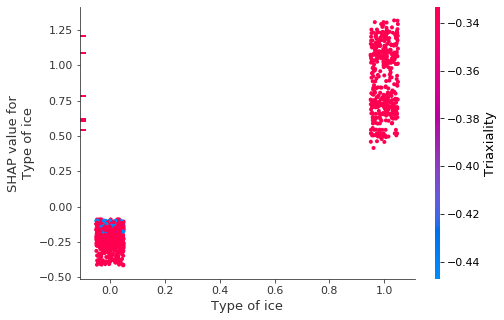

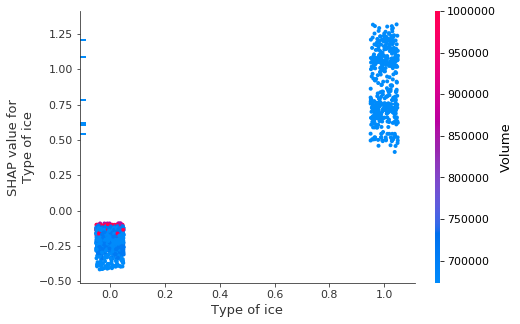

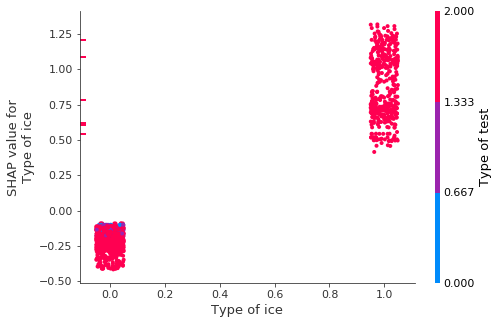

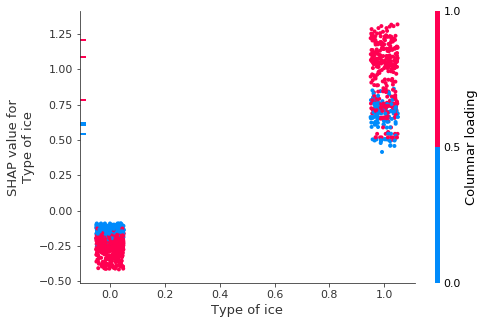

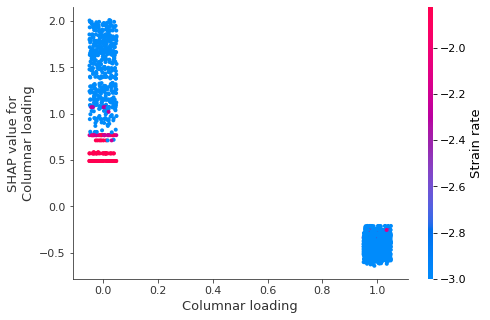

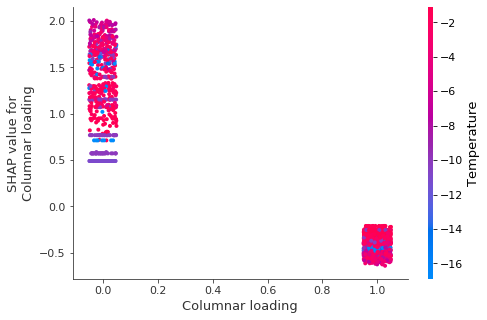

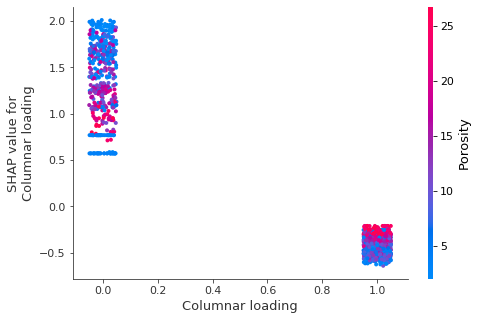

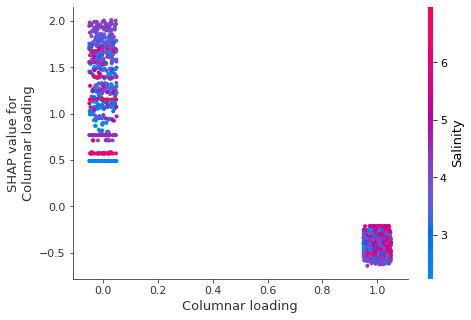

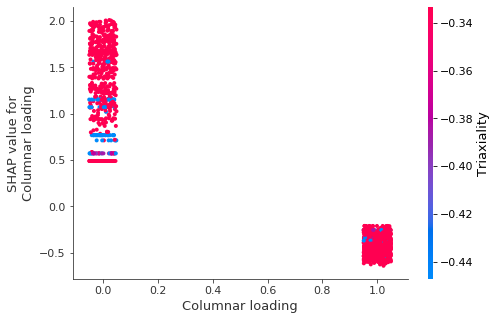

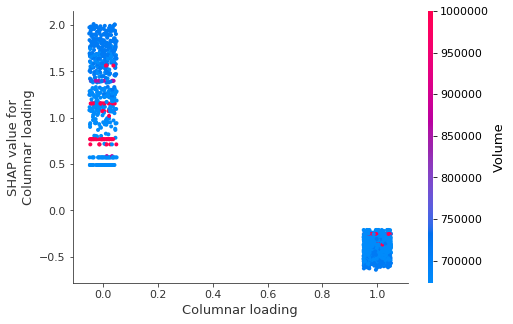

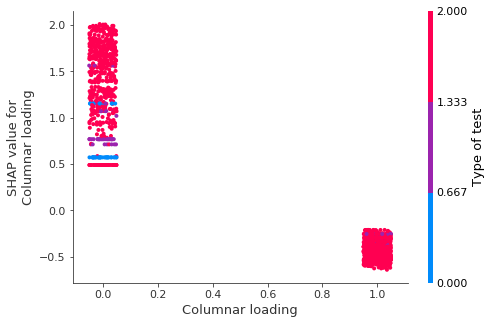

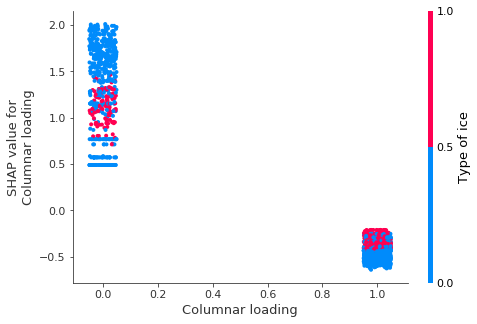

In [33]:
for feature in display_feature_names:
    for interaction_feature in display_feature_names:
        if interaction_feature != feature:
            shap.dependence_plot(feature, shap_values, X, feature_names=np.array(display_feature_names), 
                                 interaction_index=interaction_feature, x_jitter=0.1)